# **User Identification From Walking Activity**

## **Introduction**
Almost every smart phone is equipped with accelerometer, the device that measures acceleration of the phone in all the directions. It is most often used to identify the angle of the phone with respect to the direction of the gravity so that it can know a photo should be shown vertically or horizontally. It is also used in some apps for pedometers or for detecting the owner's activities such as walking and jogging. Although the data is usually not recorded, it measures acceleration every 0.03 seconds, which can generate 5MB of data in only 1 hour. Apparently it has a potential to be a great data source that contains a lot of information about the owner, not only walking or jogging but also **who is the owner**.<br><br>
In this project, I use time series data recorded by a cell phone positioned in the chest pocket, and try to identify the owners from their walking activities using machine learning techniques. The main data source used in this short summary is taken from UCI Machine Learning Repository, but I am planning to use data recorded by my families and friends in future as well as simulated datasets that mimics real walking activities.

### **Tools**
   - Analysis: IPython Notebooks
   - Machine leaning kit: scikit-learn (K-Nearest Neighbors, Decision Tree, Random Forest, SVM)
   - Data collection: UCI repository, VibSensor app, 
   - Python packages: pandas, numpy, gatspy
   - Visualization: matplotlib
   - Presentation: jupyrer nbviewer

### **Data**
**Publicly Available Dataset**<br>
The dataset collects data from an Android smartphone positioned in the chest pocket. Accelerometer Data are collected from 22 participants walking in the wild over a predefined path. Data files are separated by participant. Each file contains the following information: time, x-acceleration, y-acceleration, z-acceleration.<br>
Data Source: https://archive.ics.uci.edu/ml/datasets/User+Identification+From+Walking+Activity
<br><br>

**Other Datasets to be Used in Future**<br>
*Simulated Dataset*<br>
The simulation I coded for this project generates unique time series data for a mock walker. It will eventually be used to generate large realistic datasets as well as to perform livestream analysis. See Apendix.
<br>

*Self-Measured Dataset*<br>
VibSensor app installed in my iphone.

## **Feature selection**
Since the dataset is labeled by participant's ID number, the natural technique to employ for solving this problem is supervised classification. The dataset for each participant is time series of 3 quantities; acceleration in x, y, and z direction (hereafter denoted as $a_x$, $a_y$, and $a_z$) measured by accerometer in an Android cellphone carried in the chest pocket. See the example data for participant 1, 6, and 8 below (22 participants in total).

**Figure 1.** Acceleration time series for 3 example participants.

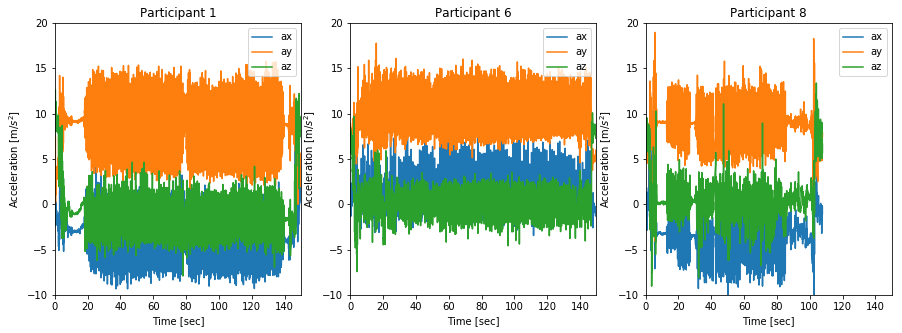

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

# read-in entire dataset
data = []
for i in range( 1, 23 ):
    data.append( pd.read_csv( 'data/%02d.csv'%i, names = [ 't', 'ax', 'ay', 'az' ]) )

# plotting class for repetitive usage
class plotting(object):
    def __init__( self, data ): self.data = data
    def plot_data( self, ID, f, alpha, title, legend=True ):
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['ax'], alpha=alpha, label="ax") # -1 for 0 index
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['ay'], alpha=alpha, label="ay")
        f.plot( self.data[ID-1]['t'], self.data[ID-1]['az'], alpha=alpha, label="az")
        f.set_xlim(0,150)
        f.set_ylim(-10,20)
        f.set_title( title )
        f.set_xlabel( 'Time [sec]' ); f.set_ylabel( r'Acceleration [m/$s^2$]' )
        if legend: f.legend( loc='upper right', fancybox=True )

# example plots for time vs. acceleration for 3 participants
p = plotting(data)
fig = plt.figure(figsize=(15,5))
f = fig.add_subplot(131); p.plot_data( 1, f, 1., 'Participant 1' )
f = fig.add_subplot(132); p.plot_data( 6, f, 1., 'Participant 6' )
f = fig.add_subplot(133); p.plot_data( 8, f, 1., 'Participant 8' )
plt.show()

The time stamp is 0.03 seconds on average (but non-uniformly sampled), and therefore the example participants 1, 6, and 8 above have several thousands of data points for each variable. Many training data points? Well, not quite. Each data point does not have much information and hardly usable as a training data point by itself: time series data have meaning only when they are analyzed as series. **The strategy we should take is, then, to divide each time series into smaller segments and use each segment as one data point to extract the features.**

### Mean and Standard Deviation
The simplest features that we first may come up with are *mean* and *standard deviation* of each variable for a given time segment. Figure below shows time series of average value of each segment with standard deviation indicated by the error bars, for the above 3 participants with a segmentation size $\Delta T=5$ (sec).

**Figure 2.** Segmented acceleration time series for 3 example participants.

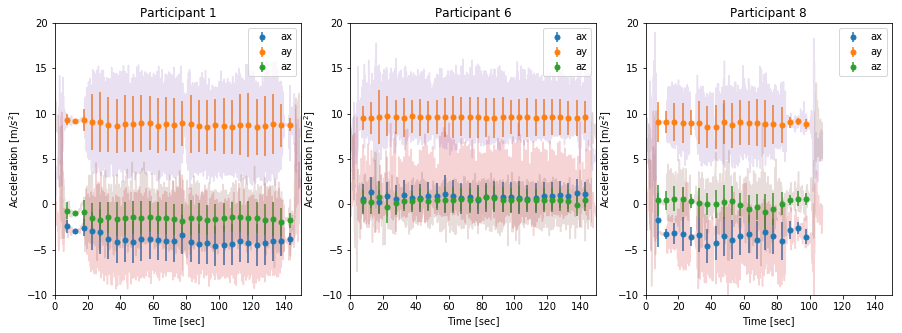

In [15]:
# parsing data into DT
class parse_data(object):
    def __init__( self, data, DT ):
        self.DT = DT
        self.data_parsed = []
        for d in data: self.data_parsed.append(self.parsing( d ))
        self.t_parsed_avg = []
        self.data_parsed_avg = []
        self.sig_parsed_avg = []
        for d in self.data_parsed:
            t_avg, d_avg, sig_avg = self.averaging( d )
            self.t_parsed_avg.append( t_avg )
            self.data_parsed_avg.append( d_avg )
            self.sig_parsed_avg.append( sig_avg )

    def parsing( self, data ):
        t_s = data['t'][0]
        t_e = t_s + self.DT
        i_s = 0
        data_parsed = []
        # need to loop since it's unevely sampled...
        for i, t in enumerate(data['t']):
            if t > t_e:
                data_parsed.append(data.iloc[i_s:i,:])
                i_s = i
                t_e = t + self.DT
        return data_parsed[1:-1]

    def averaging( self, data_parsed ):
        # calculate average and standard dev. for each segment
        t_avg = []; d_avg = []; sig = []
        for d in data_parsed:
            t_avg.append( np.average(d['t']) )
            cols = d.iloc[:,1:]
            d_avg.append( [np.average(cols[col]) for col in cols] )
            sig.append(   [np.std(    cols[col]) for col in cols] )
        d_avg = list(map( list, zip(*d_avg) ))
        sig   = list(map( list, zip(*sig  ) ))
        return t_avg,d_avg,sig

def plot_parse( par, ID, f ):
    t = par.t_parsed_avg[ID-1]; data = par.data_parsed_avg[ID-1]; sig = par.sig_parsed_avg[ID-1]
    f.errorbar( t, data[0], yerr=sig[0], fmt='.', ms=10, label='ax' )
    f.errorbar( t, data[1], yerr=sig[1], fmt='.', ms=10, label='ay' )
    f.errorbar( t, data[2], yerr=sig[2], fmt='.', ms=10, label='az' )
    plt.legend( loc='upper right' )
    

DT = 5. # segment size in second
par = parse_data( data, DT )

fig = plt.figure(figsize=(15,5))
f1 = fig.add_subplot(131); plot_parse( par, 1, f1 )
f2 = fig.add_subplot(132); plot_parse( par, 6, f2 )
f3 = fig.add_subplot(133); plot_parse( par, 8, f3 )

p = plotting( data )
p.plot_data( 1, f1, 0.2, 'Participant 1', legend=False )
p.plot_data( 6, f2, 0.2, 'Participant 6', legend=False )
p.plot_data( 8, f3, 0.2, 'Participant 8', legend=False )
plt.show()

While mean appears to be a nice feature to characterize walking style of a participant in the example above, it should be 0 for $a_x$ and $a_z$ if the segment $\Delta T$ is large compared to the time scale of few walking steps, unless the person in in a circular motion and centrifugal force comes into play. That is to say, any significant offset from 0 is most likely due to systematic errors such as the phone is tilted in the chest pocket or mechanical problems. Likewise, mean value of $a_y$ (acceleration in the vertical direction) is supposed to be equal to the gravitational acceleration ~9.8 for a reasonable value of $\Delta T$. **Mean of these variables therefore is not a good choice to be a feature** for this dataset.<br><br>
**Standard deviation, on the other hand, is a good candidate to be one of the main features.** The figures below show distribution of the 3 example participants in $\sigma_{ax}$, $\sigma_{ay}$, and $\sigma_{az}$ space for $\Delta T=5$ (left) and $1$ sec (right). Unique distributions for each participant are somewhat visible for this particular set of participants, but further features would be needed once we increase the number of the participants.

**Figure 3.** Clustering of 3 example participants in 3 dimensional space of $\sigma_{x,y,z}$, for 2 different segmentation sizes.

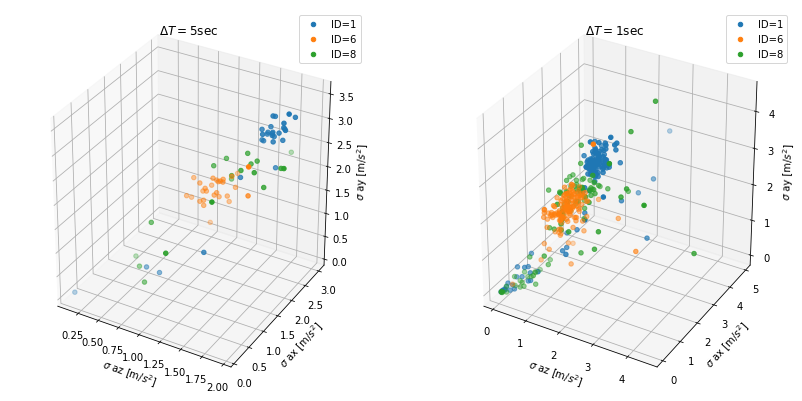

In [16]:
def plot_scatt(data,ID,f,title):
    f.scatter(data[ID[0]-1][2],data[ID[0]-1][0],data[ID[0]-1][1],label='ID=%d'%(ID[0]))
    f.scatter(data[ID[1]-1][2],data[ID[1]-1][0],data[ID[1]-1][1],label='ID=%d'%(ID[1]))
    f.scatter(data[ID[2]-1][2],data[ID[2]-1][0],data[ID[2]-1][1],label='ID=%d'%(ID[2]))
    f.set_xlabel(r'$\sigma$ az [m/$s^2$]')
    f.set_ylabel(r'$\sigma$ ax [m/$s^2$]')
    f.set_zlabel(r'$\sigma$ ay [m/$s^2$]')
    f.set_title(title)
    plt.legend()

fig = plt.figure(figsize=(14,7))
ID=[1,6,8]

par = parse_data( data, 5 ) # segment size = 5sec
plot_scatt( par.sig_parsed_avg, ID, fig.add_subplot(121,projection='3d'), r"$\Delta T=5$sec")
par = parse_data( data, 1 ) # segment size = 1sec
plot_scatt( par.sig_parsed_avg, ID, fig.add_subplot(122,projection='3d'), r"$\Delta T=1$sec")
plt.show()

### Frequency
Fourier analysis is essential in characterising walking style of the participants. Ideally we want to find a method to somehow parameterize the "shape" of the Fourier spectrum for each participant, but for now we stick to the temporal frequency of steps (number of steps per second) which is relatively easy to identify and very likely a strong feature.<br>
Here we choose magnitude of mean-subtracted acceleration to be a variable to measure walking frequency, $f$: for a given time segment, $|a|(t)=\sqrt{(a_x(t)-\bar{a_x})^2+(a_y(t)-\bar{a_y})^2+(a_z(t)-\bar{a_z})^2}$, where $\bar{a_x}$ is mean value of $a_x(t)$. Because the data is unevenly sampled in time, we use Lomb-Scargle periodogram which well approximates Fourier transform in our case. Note that mean value and standard deviation of $|a|$ also could be nice features. It is similar to $\sigma_{ax,ay,az}$ but directional information is reduced.<br>
As an example, the plots below show $|a|(t)$ in 10th time segment ($\Delta T=5$sec) of participant 8 (left), its periodogram with the peak frequency marked by the vertical line (center), and time sequence of the peak frequency with the 10th time segment is marked by the red dot (right).  

**Figure 4.** Time series of acceleration in a segment (left), its periodogram (center), and walking frequency for each segment (right) for an example participant.

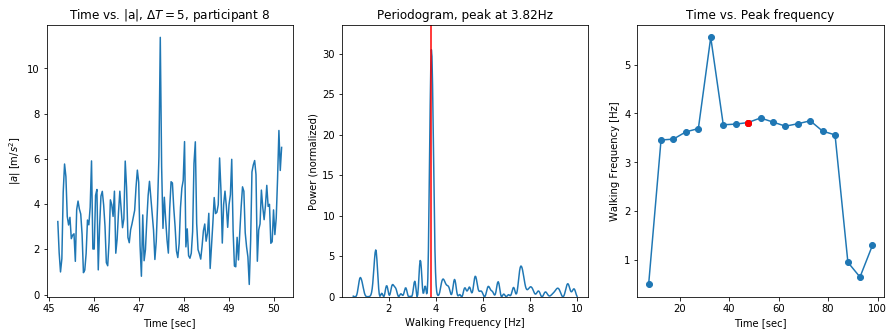

In [17]:
from gatspy.periodic import LombScargleMultibandFast
from gatspy.periodic import LombScargleFast

class Period(object):

    def get_a(self,par,ID):
        dp = par.data_parsed[ID-1]
        n_seg = len(dp)
        a=[]; t=[]
        for i_seg in range(n_seg):
            ax = dp[i_seg]['ax'] - np.average(dp[i_seg]['ax'])
            ay = dp[i_seg]['ay'] - np.average(dp[i_seg]['ay'])
            az = dp[i_seg]['az'] - np.average(dp[i_seg]['az'])
            amag = np.sqrt(ax**2+ay**2+az**2)
            a.append(amag)
            t.append(dp[i_seg]['t'])
        return(t,a)

    def get_LS(self, y ):
        N = len(y[0])
        #model = LombScargleMultibandFast(silence_warnings=True).fit(y[0], y[1])
        model = LombScargleFast(silence_warnings=True).fit(y[0], y[1])

        T = y[0][-1]-y[0][0]
        fmin = 1./T
        fmax = N/(2.*T)
        df = fmin/8.
        f = np.arange(fmin,fmax,df)
        periods = 1./f
        power = model.score(periods)

        power *= N/2 # make it equal to the normalized periodogram of NR eq. 13.8.4
        return [f, power]

    def get_fp(self,t,a,iseg):
        ti = np.array(t[iseg]); ai = np.array(a[iseg])
        f,p = self.get_LS([ti,ai])

        li = (f>1/2.)*(f<1/0.1) # period faster than 2sec, slower than 0.1sec
        ff=f[li]; fp=p[li]
        period = ff[np.argmax(fp)]
        return ti,ai,ff,fp,period

    def get_peaks(self,par,ID):
        t,a=self.get_a(par,ID)
        tseg=[]; aseg=[]; sseg=[]; pseg=[]
        for iseg in range(len(t)):
            ti,ai,ff,fp,period = self.get_fp(t,a,iseg)
            tseg.append(np.average(ti))
            aseg.append(np.average(ai))
            sseg.append(np.std(ai))
            pseg.append(period)
        return tseg,aseg,sseg,pseg

DT = 5. # segment size in second
par = parse_data( data, DT )
ID = 8
iseg = 8
per = Period()

fig = plt.figure(figsize=(15,5))
f1 = fig.add_subplot(131)
t,a = per.get_a(par,ID)
f1.plot(t[iseg],a[iseg])
f1.set_xlabel('Time [sec]')
f1.set_ylabel(r'$|a|$ [m/$s^2$]')
f1.set_title(r'Time vs. |a|, $\Delta T=5$, participant 8')

f2 = fig.add_subplot(132)
ti,ai,ff,fp,period = per.get_fp(t,a,iseg)
f2.plot(ff,fp)
f2.set_xlabel('Walking Frequency [Hz]')
f2.set_ylabel('Power (normalized)')
f2.set_title('Periodogram, peak at 3.82Hz')
ymax = np.max(fp)*1.1
f2.set_ylim(0,ymax)
f2.plot([period,period],[0,ymax],'r')

f3 = fig.add_subplot(133)
tseg,aseg,sseg,pseg=per.get_peaks(par,ID)
f3.plot(tseg,pseg,'o-')
f3.plot([tseg[iseg],tseg[iseg]],[pseg[iseg],pseg[iseg]],'ro')
f3.set_xlabel('Time [sec]')
f3.set_ylabel('Walking Frequency [Hz]')
f3.set_title('Time vs. Peak frequency')
plt.show()

As the right plot shows, participant 8 can be well characterized by ~3.7Hz of walking frequency except several outliers. Below is a scatter plot of the peak frequency and mean value of $|a|$ for the participant 1,6 and 8. It is apparent that the **walking frequency is very strong feature**. There is a big inaccuracy in finding the walking frequency $f$ (just pick the frequency of the highest power in the reasonable frequency range) and often end up with wrong result, which definitely need to be improved. 

**Figure 5.** Clustering of 3 example participants in 2 dimensional space of walking frequency and $|a|$.

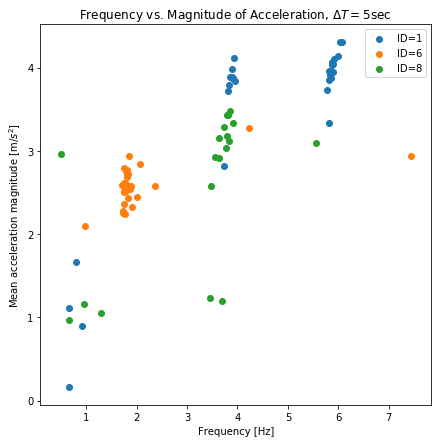

In [10]:
DT = 5. # segment size in second
par = parse_data( data, DT )
ID = [1,6,8]
per = Period()

fig = plt.figure(figsize=(7,7))
f = fig.add_subplot(111)
tseg,aseg,sseg,pseg=per.get_peaks(par,ID[0]); f.scatter(pseg,aseg,label='ID=%d'%ID[0])
tseg,aseg,sseg,pseg=per.get_peaks(par,ID[1]); f.scatter(pseg,aseg,label='ID=%d'%ID[1])
tseg,aseg,sseg,pseg=per.get_peaks(par,ID[2]); f.scatter(pseg,aseg,label='ID=%d'%ID[2])
f.set_xlabel('Frequency [Hz]')
f.set_ylabel(r'Mean acceleration magnitude [m/$s^2$]')
f.set_title(r'Frequency vs. Magnitude of Acceleration, $\Delta T=5$sec')
plt.legend()
plt.show()

## **Result of Supervised Classification**
For this preliminary analysis, the features we are going to use are standard deviation of acceleration in each direction, $\sigma_x$, $\sigma_y$, $\sigma_z$, and walking frequency (number of walking steps per second), $f$. We train the classifiers using randomly chosen 80% of all the time segments for a given segmentation size ($\Delta T=5$ sec for this result), and test using the remaining 20% to see if the classifier can identify the participant. F1-Scores calculated below are average of 100 scores from different test sets. We include 19 participants in this classification. All the classifiers used here are from scikit-learn.<br>

**K-Nearest Neighbors**<br>
F1-Score = **57.8%**<br>
Best "number of neighbor points (n_neighbors)" = 5<br>

**Decision Tree**<br>
F1-Score = **48.5%**<br>
Best "minimum number of samples required to split tree (min_samples_split)" = 2<br>

**Random Forest**<br>
F1-Score = **56.3**<br>
Best min_samples_split = 3<br>

**Supported Vector Machine**<br>
F1-Score = **59.4%** (kernel=RBF)<br>
F1-Score = **55.6%** (kernel=Polynomial)<br>
best "penalty parameter (C)" = 10<br><br><br>


Below are example visualization of decision boundaries for KNN, Decision tree, SVM, and Random Forest using only 2 features ($f$ and $\sigma_x$) and 5 participants (ID=1,3,5,7, and 8).

**Figure 6.** Visualization of decision boundaries for 3 example participants in 2 dimensional space of walking frequency and $\sigma_{x}$, for 3 different classification models.

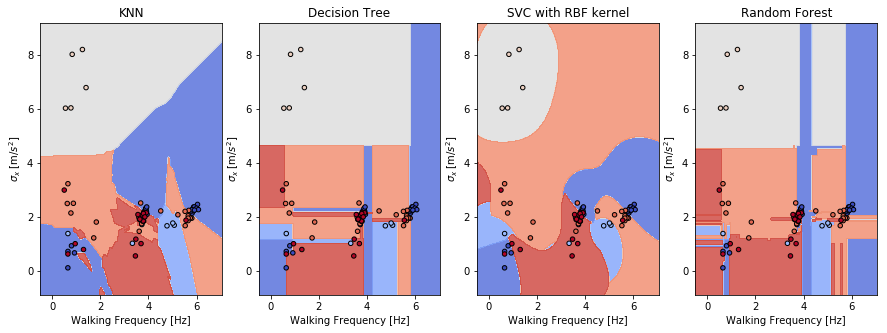

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def get_features_and_labels(DT,ID):

    par = parse_data( data, DT )
    per = Period()
    pseg=[]; sigx=[]; sigy=[]; sigz=[]; labels=[]
    for i, i_d in enumerate(ID):
        #print(i_d)
        tseg,aseg,sseg,pseg_temp = per.get_peaks(par,i_d)
        pseg.append( pseg_temp )
        sigx.append( par.sig_parsed_avg[i_d-1][0] )
        sigy.append( par.sig_parsed_avg[i_d-1][1] )
        sigz.append( par.sig_parsed_avg[i_d-1][2] )
        labels.append( np.ones((len(tseg)),dtype=int)*i_d )

    pseg = [ i for pseg_n in pseg for i in pseg_n]
    sigx = [ i for sigx_n in sigx for i in sigx_n]
    sigy = [ i for sigy_n in sigy for i in sigy_n]
    sigz = [ i for sigz_n in sigz for i in sigz_n]

    features = np.transpose([pseg,sigx,sigy,sigz]) #63, 59, 57, n_neighbors=5
    labels = [ i for labels_n in labels for i in labels_n]
    return features,labels

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

DT = 5. # segment size in second
#ID = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,19,21]
ID = [1,3,5,7,8]
features,labels = get_features_and_labels(DT,ID)

# Take the first two features.
X = features[:, :2]
y = labels

models = (KNeighborsClassifier(n_neighbors=5),
          DecisionTreeClassifier(min_samples_split=2),
          SVC(C=10),
          RandomForestClassifier(min_samples_split=3))
models = (clf.fit(X, y) for clf in models)

titles = ('KNN','Decision Tree','SVC with RBF kernel','Random Forest')

fig = plt.figure(figsize=(15,5))
#sub = [fig.add_subplot(131),fig.add_subplot(132),fig.add_subplot(133)]
sub = [fig.add_subplot(141),fig.add_subplot(142),fig.add_subplot(143),fig.add_subplot(144)]

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub):
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max()); ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Walking Frequency [Hz]')
    ax.set_ylabel(r'$\sigma_{x}$ [m/$s^2$]')

    ax.set_title(title)

plt.show()


### **Comment on the Result**
We found our best **prediction accuracy is 60%** using SVC, which is significantly better than random guess (~5%). It is, though, still very far from practical application especially if the number of participants is much larger.<br>
**The first thing we need to work on to improve the accuracy is preprocessing the training data**; currently those data points that are apparently not to be used (very small standard deviation, resting?) are included in the training data set. We should either remove them or create a new classification category for those points.<br>
**The second thing to work on, which is the core of the subject, is finding a better way to characterize the periodogram**. We crudely extracted the principal frequency by just choosing the frequency of maximum power in this preliminary test, but this is not very trustful method especially when $\Delta T$ is small. There are much more precious information hidden in other peaks in the periodograms that truely are unique for each participant.<br>


## **Future Work using Other Datasets**
### **Simulated Datasets**
One of the bottle necks of this project is its small dataset; the total number of participant is only 22 with data size of 4MB. **Larger number of participants is required for checking the performance and limitation, to improve the accuracy of the algorithm**.<br>
This problem can be solved by **simulating accelerometer outputs that mimics the real dataset**. The simulation should include both the charactericities of each person's walking style and dithering of the recorded data due to the walker's physical state, road condition, etc.<br>
The preliminary simulation described in Apendix can generate **17300 datasets** in 24 hours that each of them has duration of 180 sec, **equivalent to 40GB of data size**. The simulation also allows data analysis in **livestream** manner as each time step is calculated based on the previous timestep which is just like the walking in the real world. Example plots for 3 simulated walkers are presented below.<br>
Limitation of the current simulation is that it has only fixed number of resonant peaks in power spectrum, while real data also has many peaks at other frequencies. The next step is introducing more generalized walker simulator that has flexibility to find parameter sets that can produce further realistic data.

**Figure 7.** 3 examples of simulated accelerometer outputs

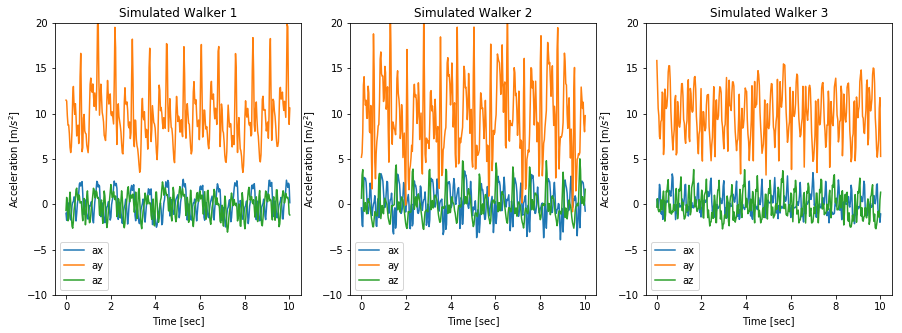

In [12]:
class walker(object):

    def __init__(self):
        #== Choose principal walking frequency
        avg_f = 1.4 # randomly choose principal frequency around avg_f
        range_f = 1.2 # possible frequency range: avg_f-range_f/2 -> avg_f+range_f/2
        self.f_p = np.array([(random.random()-0.5)*range_f+avg_f]) # principal frequency (m=1)

        #== Choose amplitude of acceleration of the principal frequency
        # Vertical direction
        avg_ay = 2. # randomly choose amplitude of principal frequency around avg_ay
        range_ay = 1. # possible amplitude range: avg_ay-range_ay/2 -> avg_ay+range_ay/2
        self.ay_p = np.array([(random.random()-0.5)*range_ay+avg_ay]) # amplitude for vertical direction

        # Other directions
        fac = 0.5
        avg_ax = avg_ay*fac # amplitude in x and z direction is usually smaller than y direction
        avg_az = avg_ay*fac
        range_ax = range_ay*fac
        range_az = range_ay*fac
        self.ax_p = np.array([(random.random()-0.5)*range_ax+avg_ax])
        self.az_p = np.array([(random.random()-0.5)*range_az+avg_az])

        #== Choose higher resonant frequencies' amplitude in semi-random order
        self.nf = 7 # consider up to nf resonant frequency
        fac = .7 # diminishing factor for higher resonant frequency, between fac and 1
        for m in range(1,self.nf+1):
            self.f_p = np.append(self.f_p,self.f_p[0]*(m+1)) # add higher mode freq.
            self.ax_p = np.append(self.ax_p, (1.-(1.-fac)*random.random())*self.ax_p[m-1] ) # add semi-random higher mode amp. 
            self.ay_p = np.append(self.ay_p, (1.-(1.-fac)*random.random())*self.ay_p[m-1] )
            self.az_p = np.append(self.az_p, (1.-(1.-fac)*random.random())*self.az_p[m-1] )

        #== Choose phase in each direction
        self.phi_x = np.array([])
        self.phi_y = np.array([])
        self.phi_z = np.array([])
        for m in range(self.nf):
            self.phi_x = np.append(self.phi_x,2.*np.pi*random.random())
            self.phi_y = np.append(self.phi_y,2.*np.pi*random.random())
            self.phi_z = np.append(self.phi_z,2.*np.pi*random.random())

        #== Average acceleration value
        self.Ax_avg = 0.
        self.Ay_avg = 9.81 # gravity
        self.Az_avg = 0.

        #== Initialize acceleration values
        self.Ax, self.Ay, self.Az = self.get_A(0.)
        # detrended values
        self.Ax_det = self.Ax
        self.Ay_det = self.Ay
        self.Az_det = self.Az

        #== Misc.
        self.dt = 0.03 # Time step. Currently fixed

        # For keeping track of average value per cycle
        P = 1./self.f_p[0] # Period
        self.nbin = int(P/self.dt)
        self.keep_Ax = np.zeros(self.nbin)
        self.keep_Ay = np.zeros(self.nbin)
        self.keep_Az = np.zeros(self.nbin)
        self.current_bin = 0

        # Run for 1 cycle for initial detrending
        self.t = -self.dt*self.nbin
        self.get_A(self.t)
        for i in range(self.nbin-1): self.advance_A()


    # Get acceleration value at t for no dithering. Used for getting initial values
    def get_A(self,t):
        Ax=0.; Ay=0.; Az=0.
        for m in range(self.nf):
            fac = 2.*np.pi*self.f_p[m]
            Ax += self.ax_p[m]*np.sin(fac*t+self.phi_x[m])
            Ay += self.ay_p[m]*np.sin(fac*t+self.phi_y[m])
            Az += self.az_p[m]*np.sin(fac*t+self.phi_z[m])
        Ax += self.Ax_avg
        Ay += self.Ay_avg
        Az += self.Az_avg
        return Ax,Ay,Az

    
    # Get acceleration values of next timestep using current time data with some randomising added
    def advance_A(self):
        dAx=0.; dAy=0.; dAz=0.
        fac_a_rand = 0.5
        for m in range(self.nf):
            fac = 2.*np.pi*self.f_p[m]
            # Dither amplitude of each mode
            del_ax_p = self.ax_p[m]*fac_a_rand*(random.random()-0.5)
            del_ay_p = self.ay_p[m]*fac_a_rand*(random.random()-0.5)
            del_az_p = self.az_p[m]*fac_a_rand*(random.random()-0.5)
            # Calculate slope
            dAx += (self.ax_p[m]+del_ax_p)*fac*np.cos(fac*self.t+self.phi_x[m])
            dAy += (self.ay_p[m]+del_ay_p)*fac*np.cos(fac*self.t+self.phi_y[m])
            dAz += (self.az_p[m]+del_az_p)*fac*np.cos(fac*self.t+self.phi_z[m])
        self.Ax += dAx*self.dt
        self.Ay += dAy*self.dt
        self.Az += dAz*self.dt
        self.t += self.dt

        # Detrending bulk evolution
        self.Ax_det = self.Ax - np.average(self.keep_Ax) + self.Ax_avg
        self.Ay_det = self.Ay - np.average(self.keep_Ay) + self.Ay_avg
        self.Az_det = self.Az - np.average(self.keep_Az) + self.Az_avg

        # For future detrending
        self.keep_Ax[self.current_bin] = self.Ax
        self.keep_Ay[self.current_bin] = self.Ay
        self.keep_Az[self.current_bin] = self.Az
        self.current_bin += 1
        if self.current_bin >= self.nbin: self.current_bin = 0

            
def get_walker(tlim):
    w = walker()
    t = np.array([])
    Ax = np.array([])
    Ay = np.array([])
    Az = np.array([])
    w.get_A(w.t)
    while w.t<tlim:
        w.advance_A()
        Ax = np.append(Ax,w.Ax_det)
        Ay = np.append(Ay,w.Ay_det)
        Az = np.append(Az,w.Az_det)
        t = np.append(t,w.t)
    return t,Ax,Ay,Az

def pl_walker(t,Ax,Ay,Az,f,title):
    f.plot(t,Ax,label='ax')
    f.plot(t,Ay,label='ay')
    f.plot(t,Az,label='az')
    f.set_ylim(-10,20)
    f.set_xlabel('Time [sec]')
    f.set_ylabel( r'Acceleration [m/$s^2$]' )
    f.set_title(title)
    plt.legend()

def pl_walkers():
    tlim = 10.
    t1,Ax1,Ay1,Az1 = get_walker(tlim)
    t2,Ax2,Ay2,Az2 = get_walker(tlim)
    t3,Ax3,Ay3,Az3 = get_walker(tlim)

    fig = plt.figure(figsize=(15,5))
    f = fig.add_subplot(131); pl_walker(t1,Ax1,Ay1,Az1,f,'Simulated Walker 1')
    f = fig.add_subplot(132); pl_walker(t2,Ax2,Ay2,Az2,f,'Simulated Walker 2')
    f = fig.add_subplot(133); pl_walker(t3,Ax3,Ay3,Az3,f,'Simulated Walker 3')
    
pl_walkers()
plt.show()

### **Self-measured Datasets**
I am planning to ask my friends to record their walking activities and use the data for this project. Plots below are for my, my wife's, and my dog's data. Apparently the cellphone was moving around in the pochette on my dog... I should consider this kind of situations, too.

**Figure 8.** Examples of self-measured acceleration timse series.

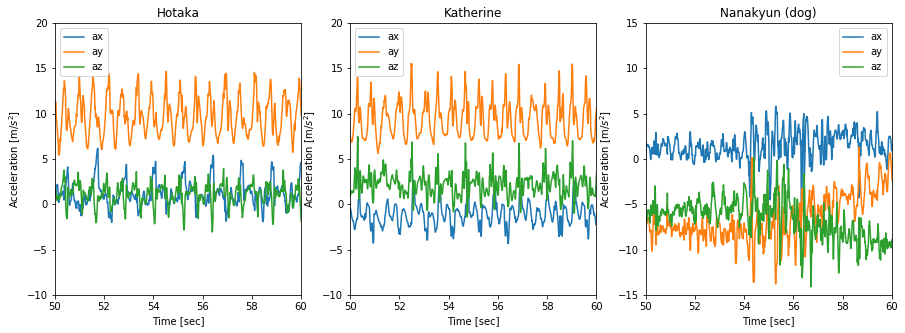

In [13]:
data_h = pd.read_csv( 'data_family/hotaka_walk.csv', names = [ 't', 'ax', 'ay', 'az' ])
data_k = pd.read_csv( 'data_family/katherine_walk.csv', names = [ 't', 'ax', 'ay', 'az' ])
data_n = pd.read_csv( 'data_family/nanakyun_walk_run.csv', names = [ 't', 'ax', 'ay', 'az' ])

def pl(data,f,title,yl,yh):
    f.plot(data['t'],data['ax'],label='ax')
    f.plot(data['t'],data['ay'],label='ay')
    f.plot(data['t'],data['az'],label='az')
    f.set_title(title)
    f.set_xlim(50,60)
    f.set_ylim(yl,yh)
    f.set_xlabel('Time [sec]')
    f.set_ylabel( r'Acceleration [m/$s^2$]' )
    plt.legend()

fig = plt.figure(figsize=(15,5))
f=fig.add_subplot(131); pl(data_h,f,'Hotaka',-10,20)
f=fig.add_subplot(132); pl(data_k,f,'Katherine',-10,20)
f=fig.add_subplot(133); pl(data_n,f,'Nanakyun (dog)',-15,15)

plt.show()

## **Apendix**
The detailed method for the simulation is the following.<br>
<br>
First, we choose basis power spectrum and phase of the acceleration time series in each direction for a walker. We simplify this process by randomly choosing 1 principal frequency peak, which corresponds to the frequency of walking steps, with randomly chosen power (note "random" here still has arbitrarily chosen upper and lower limits). We then add 7 peaks of the resonant frequencies of the walking frequency with semi-randomly descending power. We then add randomly chosen phases to each resonant frequencies. This process gives an unique analytic expression $a(t)$ of the basis time series for each walker.<br>
<br>
We then start from an initial value $a(t=0)$ using the analytic expression. The next value, $a(t+dt)$ is calculated as $a(t+dt)=a(t)+\left(\frac{da}{dt}\right)_{dither}dt$ where $\frac{da}{dt}$ is found from the analytic expression and the subscript $dither$ means the expression contains small random deviation from the analytic expression that changes every step. Here we chose the randomness to be random 25% deviation in power at each resonant frequency.
